# IMPORTS

In [1]:
import kagglehub
import os
import random
from sklearn.model_selection import train_test_split
import shutil
import numpy as np
from tensorflow.keras import layers, models,optimizers
from tensorflow.keras.regularizers import l2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
import cv2
import tensorflow as tf
from transformers import ViTForImageClassification, ViTImageProcessor, TrainingArguments, Trainer,ViTFeatureExtractor,AutoImageProcessor
import torch
from tensorflow.keras import layers, models,optimizers
from evaluate import load
from datasets import load_dataset
import tensorflow as tf
from ultralytics import YOLO

from roboflow import Roboflow
from PIL import Image
from collections import defaultdict
import matplotlib.pyplot as plt

c:\Users\adria\anaconda3\envs\LSE\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# DESCARGAR DATASET

In [2]:
# Download latest version
path = kagglehub.dataset_download("kirlelea/spanish-sign-language-alphabet-static")

print("Path to dataset files:", path)

100%|██████████| 4.92G/4.92G [43:45<00:00, 2.01MB/s]  

Extracting files...


Path to dataset files: C:\Users\User\.cache\kagglehub\datasets\kirlelea\spanish-sign-language-alphabet-static\versions\1


# EXPLORACION DE DATOS

In [7]:
dataset_dir = "fondo_blanco/"
conteo_imagenes = {}

for cls in sorted(os.listdir(dataset_dir)):
    cls_path = os.path.join(dataset_dir, cls)
    if os.path.isdir(cls_path):
        imagenes = [f for f in os.listdir(cls_path) if f.endswith('.JPG')]
        conteo_imagenes[cls] = len(imagenes)

## Mostrar resultados ordenados
for cls, count in sorted(conteo_imagenes.items(), key=lambda x: x[1]):
    print(f"{cls:30s} -> {count} imágenes")

R                              -> 90 imágenes
B                              -> 95 imágenes
O                              -> 97 imágenes
C                              -> 98 imágenes
S                              -> 100 imágenes
A                              -> 102 imágenes
D                              -> 102 imágenes
T                              -> 102 imágenes
E                              -> 103 imágenes
F                              -> 105 imágenes
G                              -> 108 imágenes
K                              -> 108 imágenes
U                              -> 108 imágenes
P                              -> 110 imágenes
N                              -> 111 imágenes
L                              -> 112 imágenes
I                              -> 113 imágenes
M                              -> 114 imágenes
Q                              -> 120 imágenes


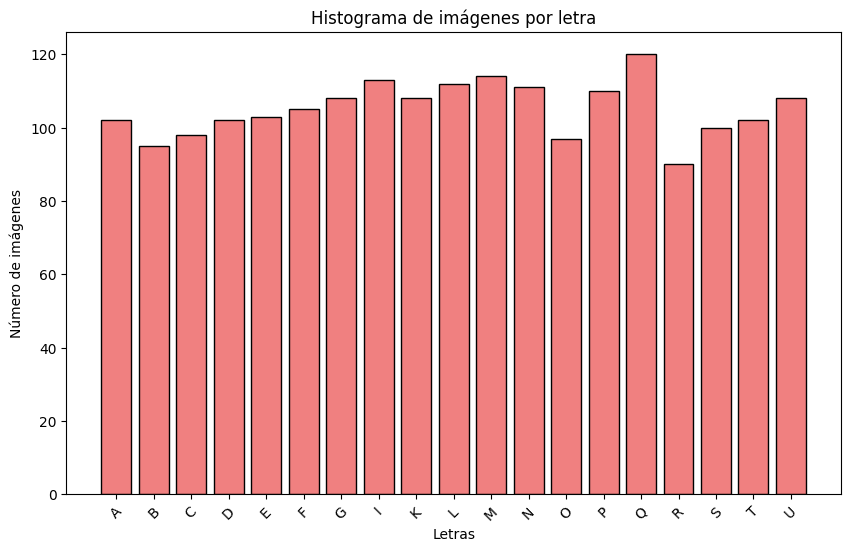

In [8]:
counts = list(conteo_imagenes.values())
letters = list(conteo_imagenes.keys())

plt.figure(figsize=(10,6))
plt.bar(letters, counts, color="lightcoral", edgecolor="black")
plt.xlabel("Letras")
plt.ylabel("Número de imágenes")
plt.title("Histograma de imágenes por letra")
plt.xticks(rotation=45)
plt.show()

Imagen cargada: (4288, 2408)


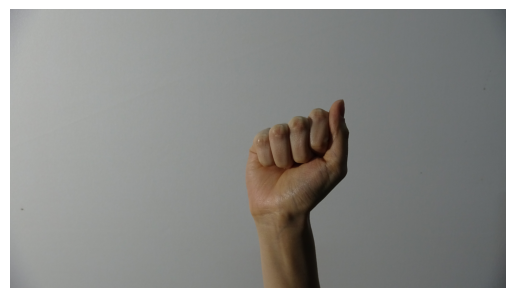

In [9]:
img = Image.open("fondo_blanco/A/DSC00884.JPG")
print("Imagen cargada:", img.size)


plt.imshow(img)
plt.axis("off") 
plt.show()

# DIVISIÓN EN TRAIN, TEST, VAL

In [10]:
## Definimos los paths
ORIGINAL_DATASET_DIR = './fondo_blanco'
BASE_OUTPUT_DIR = './fondo_blanco_split'

## Porcentajes; he optado por generar sets de train, test y validación.
## Pero podéis variar los porcentajes
train_pct = 0.7
val_pct = 0.15
test_pct = 0.15

## Crear estructura de carpetas
splits = ['train', 'val', 'test']
classes = os.listdir(ORIGINAL_DATASET_DIR)
classes = [cls for cls in classes if os.path.isdir(os.path.join(ORIGINAL_DATASET_DIR, cls))]

for split in splits:
    for cls in classes:
        os.makedirs(os.path.join(BASE_OUTPUT_DIR, split, cls), exist_ok=True)

## Dividir y copiar imágenes
for cls in classes:
    cls_path = os.path.join(ORIGINAL_DATASET_DIR, cls)
    images = [f for f in os.listdir(cls_path) if f.endswith('.JPG')]
    random.shuffle(images)

    # Asignación predeterminada
    train, val, test = [], [], []

    if len(images) >= 3:
        train, temp = train_test_split(images, train_size=train_pct, random_state=42)
        val, test = train_test_split(temp, test_size=test_pct / (test_pct + val_pct), random_state=42)
    else:
        # Si hay muy pocas imágenes, lo mandamos todo al entrenamiento
        train = images
        print(f"[Aviso] Clase '{cls}' tiene muy pocas imágenes ({len(images)}). Se asignan todas a entrenamiento.")

    for img_list, split in zip([train, val, test], ['train', 'val', 'test']):
        for img in img_list:
            src = os.path.join(cls_path, img)
            dst = os.path.join(BASE_OUTPUT_DIR, split, cls, img)
            shutil.copyfile(src, dst)

# NORMALIZACIÓN DE IMÁGENES


In [11]:
input_dir = './fondo_blanco_split/test'
output_dir = './fondo_blanco_split/test_norm'
target_size=(512, 512)

for clase in os.listdir(input_dir):
        clase_path = os.path.join(input_dir, clase)
        if not os.path.isdir(clase_path):
            continue

        output_clase_path = os.path.join(output_dir, clase)
        os.makedirs(output_clase_path, exist_ok=True)

        for nombre_img in os.listdir(clase_path):
            img_path = os.path.join(clase_path, nombre_img)
            try:
                img = Image.open(img_path,'r').convert('RGB')
                img_resized = img.resize(target_size)
                arr = np.asarray(img_resized).astype(np.float32) / 255.0
                img_norm = Image.fromarray((arr * 255).astype(np.uint8))
                output_img_path = os.path.join(output_clase_path, nombre_img)
                img_norm.save(output_img_path)
            except Exception as e:
                print(f"Error con {img_path}: {e}")

In [12]:
input_dir = './fondo_blanco_split/val'
output_dir = './fondo_blanco_split/val_norm'
target_size=(512, 512)

for clase in os.listdir(input_dir):
        clase_path = os.path.join(input_dir, clase)
        if not os.path.isdir(clase_path):
            continue

        output_clase_path = os.path.join(output_dir, clase)
        os.makedirs(output_clase_path, exist_ok=True)

        for nombre_img in os.listdir(clase_path):
            img_path = os.path.join(clase_path, nombre_img)
            try:
                img = Image.open(img_path,'r').convert('RGB')
                img_resized = img.resize(target_size)
                arr = np.asarray(img_resized).astype(np.float32) / 255.0
                img_norm = Image.fromarray((arr * 255).astype(np.uint8))
                output_img_path = os.path.join(output_clase_path, nombre_img)
                img_norm.save(output_img_path)
            except Exception as e:
                print(f"Error con {img_path}: {e}")

In [13]:
input_dir = './fondo_blanco_split/train'
output_dir = './fondo_blanco_split/train_norm'
target_size=(512, 512)

for clase in os.listdir(input_dir):
        clase_path = os.path.join(input_dir, clase)
        if not os.path.isdir(clase_path):
            continue

        output_clase_path = os.path.join(output_dir, clase)
        os.makedirs(output_clase_path, exist_ok=True)

        for nombre_img in os.listdir(clase_path):
            img_path = os.path.join(clase_path, nombre_img)
            try:
                img = Image.open(img_path,'r').convert('RGB')
                img_resized = img.resize(target_size)
                arr = np.asarray(img_resized).astype(np.float32) / 255.0
                img_norm = Image.fromarray((arr * 255).astype(np.uint8))
                output_img_path = os.path.join(output_clase_path, nombre_img)
                img_norm.save(output_img_path)
            except Exception as e:
                print(f"Error con {img_path}: {e}")

# DATA AUGMENTATION

In [14]:
train_datagen = ImageDataGenerator(
    rotation_range=40,        
    width_shift_range=0.2,     
    height_shift_range=0.2,    
    shear_range=0.2,           
    zoom_range=0.2,            
    horizontal_flip=True,      
    fill_mode='nearest'        
)

In [15]:
train_generator = train_datagen.flow_from_directory(
    './fondo_blanco_split/train_norm',
    target_size=(512, 512),
    batch_size=16,
    class_mode='sparse'
)

val_generator = train_datagen.flow_from_directory(
    './fondo_blanco_split/val_norm',
    target_size=(512, 512),
    batch_size=16,
    class_mode='sparse'
)

Found 1808 images belonging to 19 classes.
Found 562 images belonging to 19 classes.


In [16]:
num_classes = train_generator.num_classes

(16, 512, 512, 3)


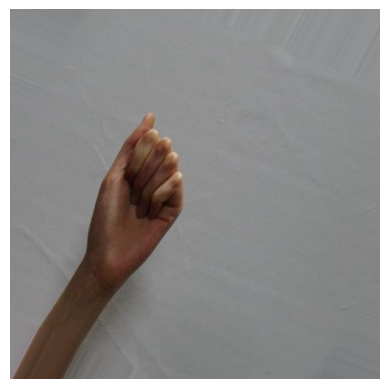

(16, 512, 512, 3)


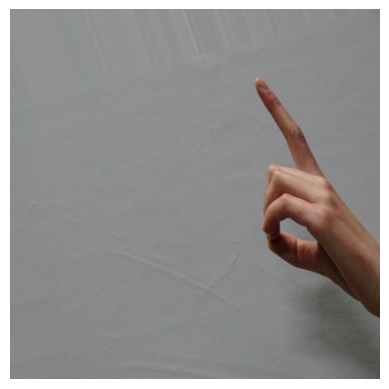

(16, 512, 512, 3)


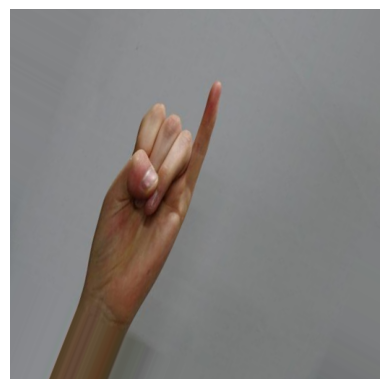

(16, 512, 512, 3)


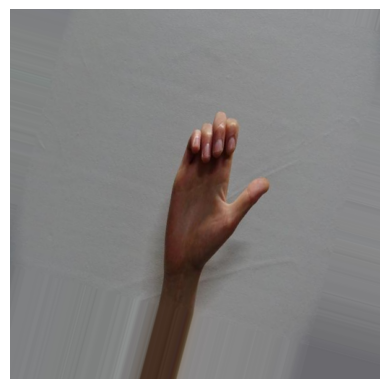

In [17]:
# Mostrar imagen aumentada
for _ in range(4):
    img, label = train_generator.__getitem__(0)
    if img.max() <= 1.0:
        img = (img * 255).astype('uint8')
    else:
        img = img.astype('uint8')
    print(img.shape) 
    plt.imshow(img[_])
    plt.axis("off")
    plt.show()

# CNN


In [5]:
model = models.Sequential([
    layers.Conv2D(32, 3, activation='relu', kernel_regularizer=l2(1e-4), padding='same', input_shape=(512, 512, 3)),
    layers.BatchNormalization(),
    layers.Conv2D(32, 3, activation='relu', kernel_regularizer=l2(1e-4), padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(),
    layers.SpatialDropout2D(0.2),

    layers.Conv2D(64, 3, activation='relu', kernel_regularizer=l2(1e-4), padding='same'),
    layers.BatchNormalization(),
    layers.Conv2D(64, 3, activation='relu', kernel_regularizer=l2(1e-4), padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(),
    layers.SpatialDropout2D(0.2),

    layers.Conv2D(128, 3, activation='relu', kernel_regularizer=l2(1e-4), padding='same'),
    layers.BatchNormalization(),
    layers.Conv2D(128, 3, activation='relu', kernel_regularizer=l2(1e-4), padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(),
    layers.SpatialDropout2D(0.2),
    layers.GlobalAveragePooling2D(),

    layers.Dense(128, activation='relu', kernel_regularizer=l2(1e-4)),
    layers.BatchNormalization(),
    layers.Dropout(0.2),
    layers.Dense(num_classes, activation='softmax')
])

optimizer = optimizers.AdamW(learning_rate=1e-3, weight_decay=1e-5)

model.compile(
    optimizer=optimizer,
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

c:\Users\User\anaconda3\envs\cnn\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [6]:
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=5
)

c:\Users\User\anaconda3\envs\cnn\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/5
87/87 ━━━━━━━━━━━━━━━━━━━━ 445s 5s/step - accuracy: 0.0979 - loss: 3.3453 - val_accuracy: 0.0468 - val_loss: 33.7670
Epoch 2/5
87/87 ━━━━━━━━━━━━━━━━━━━━ 439s 5s/step - accuracy: 0.1423 - loss: 2.8449 - val_accuracy: 0.0468 - val_loss: 18.4151
Epoch 3/5
87/87 ━━━━━━━━━━━━━━━━━━━━ 421s 5s/step - accuracy: 0.1987 - loss: 2.5783 - val_accuracy: 0.0836 - val_loss: 7.1147
Epoch 4/5
87/87 ━━━━━━━━━━━━━━━━━━━━ 420s 5s/step - accuracy: 0.2223 - loss: 2.4079 - val_accuracy: 0.0970 - val_loss: 3.7685
Epoch 5/5
87/87 ━━━━━━━━━━━━━━━━━━━━ 444s 5s/step - accuracy: 0.2812 - loss: 2.2660 - val_accuracy: 0.0736 - val_loss: 4.3201


In [19]:

model = models.Sequential([
    layers.Conv2D(32, 3, activation='relu',kernel_regularizer=l2(1e-4)),
    layers.BatchNormalization(),
    layers.Conv2D(32, 3, activation='relu',kernel_regularizer=l2(1e-4)),
    layers.BatchNormalization(),
    layers.MaxPooling2D(),
    layers.Dropout(0.2),
    layers.Conv2D(64, 3, activation='relu',kernel_regularizer=l2(1e-4)),
    layers.BatchNormalization(),
    layers.Conv2D(64, 3, activation='relu',kernel_regularizer=l2(1e-4)),
    layers.BatchNormalization(),
    layers.MaxPooling2D(),
    layers.Dropout(0.2),
    layers.GlobalAveragePooling2D(),
    layers.Dropout(0.2),

    layers.Dense(32, activation='relu',kernel_regularizer=l2(1e-4)),
    layers.BatchNormalization(),
    layers.Dropout(0.3),
    layers.Dense(num_classes, activation='softmax')
])

optimizer = optimizers.AdamW(learning_rate=1e-3, weight_decay=1e-5)
model.compile(
    optimizer=optimizer,  
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [28]:
history = model.fit(
    train_generator,
    epochs=20,
    validation_data=val_generator,
)

Epoch 1/20
87/87 ━━━━━━━━━━━━━━━━━━━━ 185s 2s/step - accuracy: 0.1164 - loss: 3.1452 - val_accuracy: 0.0468 - val_loss: 7.5769
Epoch 2/20
87/87 ━━━━━━━━━━━━━━━━━━━━ 185s 2s/step - accuracy: 0.1817 - loss: 2.6957 - val_accuracy: 0.0502 - val_loss: 20.0577
Epoch 3/20
87/87 ━━━━━━━━━━━━━━━━━━━━ 186s 2s/step - accuracy: 0.2087 - loss: 2.5266 - val_accuracy: 0.0602 - val_loss: 8.4298
Epoch 4/20
87/87 ━━━━━━━━━━━━━━━━━━━━ 184s 2s/step - accuracy: 0.3054 - loss: 2.1259 - val_accuracy: 0.1104 - val_loss: 4.7408
Epoch 5/20
87/87 ━━━━━━━━━━━━━━━━━━━━ 182s 2s/step - accuracy: 0.3307 - loss: 1.9772 - val_accuracy: 0.2140 - val_loss: 2.3380
Epoch 6/20
87/87 ━━━━━━━━━━━━━━━━━━━━ 182s 2s/step - accuracy: 0.3651 - loss: 1.8717 - val_accuracy: 0.1204 - val_loss: 5.3457
Epoch 7/20
87/87 ━━━━━━━━━━━━━━━━━━━━ 182s 2s/step - accuracy: 0.3933 - loss: 1.7758 - val_accuracy: 0.0836 - val_loss: 14.4494
Epoch 8/20
87/87 ━━━━━━━━━━━━━━━━━━━━ 182s 2s/step - accuracy: 0.4411 - loss: 1.6177 - val_accuracy: 0.0602 -

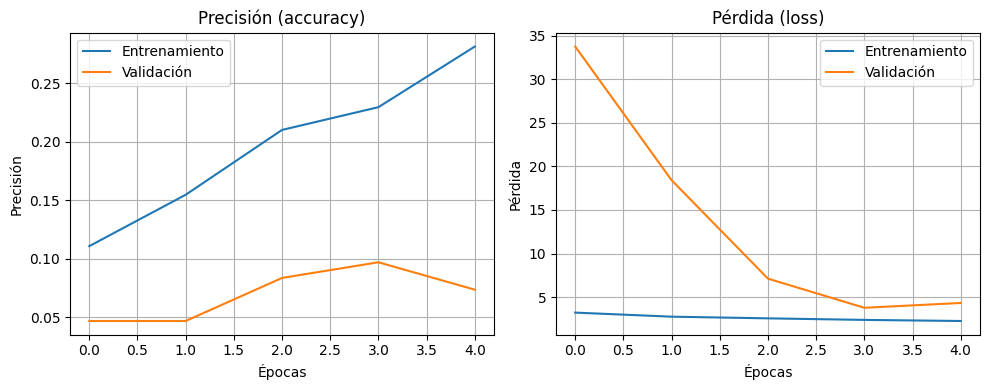

In [7]:

# Precisión (accuracy)
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Entrenamiento')
plt.plot(history.history['val_accuracy'], label='Validación')
plt.title('Precisión (accuracy)')
plt.xlabel('Épocas')
plt.ylabel('Precisión')
plt.legend()
plt.grid(True)

# Pérdida (loss)
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Entrenamiento')
plt.plot(history.history['val_loss'], label='Validación')
plt.title('Pérdida (loss)')
plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

In [8]:
test_dir = "./fondo_blanco_split/test_norm"

test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    test_dir,
    image_size=(512, 512),
    batch_size=64
    
)

# Evaluar el modelo
loss,acc =model.evaluate(test_ds)
print(f"Precisión en test: {acc:.2f}")

Found 309 files belonging to 19 classes.
5/5 ━━━━━━━━━━━━━━━━━━━━ 12s 2s/step - accuracy: 0.0780 - loss: 4.1192
Precisión en test: 0.08


# Best CNN Model Summary

In [18]:
bestCNN = models.Sequential([
    layers.Conv2D(32, 3, activation='relu',kernel_regularizer=l2(1e-4)),
    layers.BatchNormalization(),
    layers.MaxPooling2D(),
    layers.Dropout(0.2),

    layers.Conv2D(64, 3, activation='relu',kernel_regularizer=l2(1e-4)),
    layers.BatchNormalization(),
    layers.MaxPooling2D(),
    layers.Dropout(0.2),

    layers.Conv2D(128, 3, activation='relu',kernel_regularizer=l2(1e-4)),
    layers.BatchNormalization(),
    layers.MaxPooling2D(),

    layers.Conv2D(256, 3, activation='relu',kernel_regularizer=l2(1e-4)),
    layers.BatchNormalization(),
    layers.MaxPooling2D(),
    layers.Dropout(0.2),
    layers.GlobalAveragePooling2D(),
    layers.Dropout(0.2),
    
    layers.Dense(128, activation='relu',kernel_regularizer=l2(1e-4)),
    layers.BatchNormalization(),
    layers.Dropout(0.3),
    layers.Dense(num_classes, activation='softmax')])

optimizer = optimizers.AdamW(learning_rate=1e-3, weight_decay=1e-5)
bestCNN.compile(
    optimizer=optimizer,  
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [20]:
bestCNN_history = bestCNN.fit(
    train_generator,
    epochs=20,
    validation_data=val_generator,
)

Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.


Epoch 1/20
113/113 ━━━━━━━━━━━━━━━━━━━━ 380s 3s/step - accuracy: 0.1287 - loss: 3.2312 - val_accuracy: 0.0641 - val_loss: 7.8739
Epoch 2/20
113/113 ━━━━━━━━━━━━━━━━━━━━ 363s 3s/step - accuracy: 0.2215 - loss: 2.5121 - val_accuracy: 0.1210 - val_loss: 3.5548
Epoch 3/20
113/113 ━━━━━━━━━━━━━━━━━━━━ 356s 3s/step - accuracy: 0.3706 - loss: 2.0143 - val_accuracy: 0.0890 - val_loss: 6.4647
Epoch 4/20
113/113 ━━━━━━━━━━━━━━━━━━━━ 354s 3s/step - accuracy: 0.4705 - loss: 1.6762 - val_accuracy: 0.0801 - val_loss: 6.5796
Epoch 5/20
113/113 ━━━━━━━━━━━━━━━━━━━━ 353s 3s/step - accuracy: 0.4975 - loss: 1.5006 - val_accuracy: 0.1833 - val_loss: 5.0203
Epoch 6/20
113/113 ━━━━━━━━━━━━━━━━━━━━ 353s 3s/step - accuracy: 0.5867 - loss: 1.2664 - val_accuracy: 0.0907 - val_loss: 12.5221
Epoch 7/20
113/113 ━━━━━━━━━━━━━━━━━━━━ 353s 3s/step - accuracy: 0.5916 - loss: 1.2666 - val_accuracy: 0.0819 - val_loss: 13.7259
Epoch 8/20
113/113 ━━━━━━━━━━━━━━━━━━━━ 353s 3s/step - accuracy: 0.6274 - loss: 1.1487 - val_ac

In [21]:
bestCNN.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)               │ (None, 510, 510, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 510, 510, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 255, 255, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 255, 255, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 253, 253, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 253, 253, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 126, 126, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 126, 126, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 124, 124, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 124, 124, 128)  │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 62, 62, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 60, 60, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 60, 60, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 30, 30, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 30, 30, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 256)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 19)             │         2,451 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,276,155 (4.87 MB)

 Trainable params: 424,979 (1.62 MB)

 Non-trainable params: 1,216 (4.75 KB)

 Optimizer params: 849,960 (3.24 MB)

In [22]:
test_dir = "./fondo_blanco_split/test_norm"

test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    test_dir,
    image_size=(512, 512),
    batch_size=64
    
)

# Evaluar el modelo
loss,acc = bestCNN.evaluate(test_ds)
print(f"Precisión en test: {acc:.2f}")

Found 570 files belonging to 19 classes.
9/9 ━━━━━━━━━━━━━━━━━━━━ 16s 2s/step - accuracy: 0.4223 - loss: 3.6156
Precisión en test: 0.42


# FINE-TUNING

In [5]:
train_datagen = ImageDataGenerator(
    rotation_range=40,         
    width_shift_range=0.2,    
    height_shift_range=0.2,    
    shear_range=0.2,           
    zoom_range=0.2,            
    horizontal_flip=True,     
    fill_mode='nearest'        
)
train_generator = train_datagen.flow_from_directory(
    './fondo_blanco_split/train_norm',
    target_size=(512, 512),
    batch_size=16,
    class_mode='sparse'
)

val_generator = train_datagen.flow_from_directory(
    './fondo_blanco_split/val_norm',
    target_size=(512, 512),
    batch_size=16,
    class_mode='sparse'
)
num_classes = train_generator.num_classes

Found 1390 images belonging to 19 classes.
Found 299 images belonging to 19 classes.


In [6]:
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(512, 512, 3))
base_model.trainable = False 

In [7]:
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dropout(0.2),
    layers.Dense(128, activation='relu'),
    layers.Dense(num_classes, activation='softmax') 
])


optimizer = optimizers.AdamW(learning_rate=1e-3, weight_decay=1e-5)
model.compile(
    optimizer=optimizer, 
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)


In [8]:
history = model.fit(
    train_generator,
    epochs=10,
    validation_data=val_generator,)

c:\Users\User\anaconda3\envs\cnn\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
87/87 ━━━━━━━━━━━━━━━━━━━━ 160s 2s/step - accuracy: 0.2651 - loss: 2.5143 - val_accuracy: 0.6656 - val_loss: 1.0778
Epoch 2/10
87/87 ━━━━━━━━━━━━━━━━━━━━ 161s 2s/step - accuracy: 0.7263 - loss: 0.9409 - val_accuracy: 0.8428 - val_loss: 0.5644
Epoch 3/10
87/87 ━━━━━━━━━━━━━━━━━━━━ 160s 2s/step - accuracy: 0.8365 - loss: 0.5573 - val_accuracy: 0.8930 - val_loss: 0.3949
Epoch 4/10
87/87 ━━━━━━━━━━━━━━━━━━━━ 159s 2s/step - accuracy: 0.9014 - loss: 0.3847 - val_accuracy: 0.9164 - val_loss: 0.2993
Epoch 5/10
87/87 ━━━━━━━━━━━━━━━━━━━━ 159s 2s/step - accuracy: 0.9428 - loss: 0.2452 - val_accuracy: 0.9030 - val_loss: 0.2888
Epoch 6/10
87/87 ━━━━━━━━━━━━━━━━━━━━ 159s 2s/step - accuracy: 0.9264 - loss: 0.2741 - val_accuracy: 0.9599 - val_loss: 0.1692
Epoch 7/10
87/87 ━━━━━━━━━━━━━━━━━━━━ 158s 2s/step - accuracy: 0.9562 - loss: 0.1755 - val_accuracy: 0.9532 - val_loss: 0.1765
Epoch 8/10
87/87 ━━━━━━━━━━━━━━━━━━━━ 157s 2s/step - accuracy: 0.9406 - loss: 0.2190 - val_accuracy: 0.9532 - v

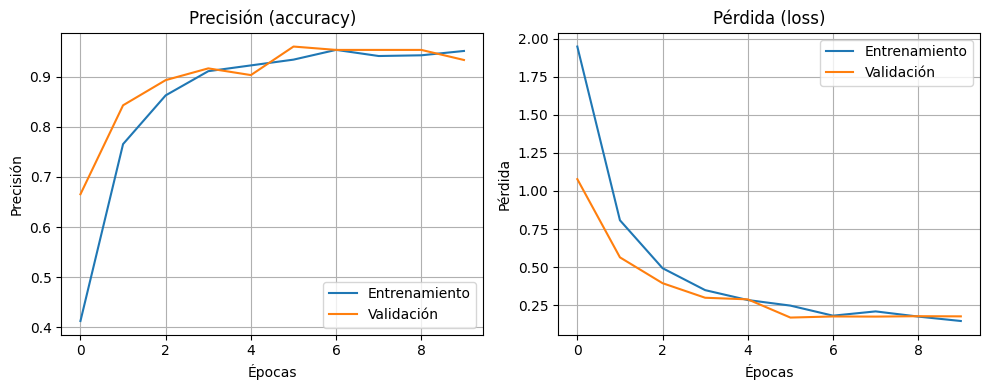

In [9]:
# Precisión (accuracy)
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Entrenamiento')
plt.plot(history.history['val_accuracy'], label='Validación')
plt.title('Precisión (accuracy)')
plt.xlabel('Épocas')
plt.ylabel('Precisión')
plt.legend()
plt.grid(True)

# Pérdida (loss)
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Entrenamiento')
plt.plot(history.history['val_loss'], label='Validación')
plt.title('Pérdida (loss)')
plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.legend()
plt.grid(True)

plt.tight_layout()

In [ ]:
base_model.trainable = True
for layer in base_model.layers[:100]:
    layer.trainable = False
optimizer = optimizers.AdamW(learning_rate=1e-3, weight_decay=1e-5)

model.compile(optimizer=optimizer,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
history = model.fit(
   train_generator,
    epochs=5,
    validation_data=val_generator,)

In [ ]:
# Precisión (accuracy)
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Entrenamiento')
plt.plot(history.history['val_accuracy'], label='Validación')
plt.title('Precisión (accuracy)')
plt.xlabel('Épocas')
plt.ylabel('Precisión')
plt.legend()
plt.grid(True)

# Pérdida (loss)
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Entrenamiento')
plt.plot(history.history['val_loss'], label='Validación')
plt.title('Pérdida (loss)')
plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.legend()
plt.grid(True)

In [ ]:
test_dir = "./fondo_blanco_split/test_norm"

test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    test_dir,
    image_size=(512, 512),
    batch_size=64
    
)


# Evaluar el modelo
loss,acc =model.evaluate(test_ds)
print(f"Precisión en test: {acc:.2f}")

Found 309 files belonging to 19 classes.
5/5 ━━━━━━━━━━━━━━━━━━━━ 30s 6s/step - accuracy: 0.9669 - loss: 0.1110
Precisión en test: 0.96


In [12]:
model.save("modelo_finetune.keras")

# VISUAL TRANSFORMER

In [4]:
train_dataset = load_dataset("imagefolder", data_dir="./fondo_blanco_split/train_norm",split='train')
val_dataset = load_dataset("imagefolder", data_dir="./fondo_blanco_split/val_norm", split='train')
test_dataset = load_dataset("imagefolder", data_dir="./fondo_blanco_split/test_norm", split='train')

In [3]:
model_id = 'google/vit-base-patch16-224-in21k'
feature_extractor = ViTFeatureExtractor.from_pretrained(
    model_id
)

c:\Users\User\anaconda3\envs\cnn\lib\site-packages\transformers\models\vit\feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(


In [5]:
def preprocess(batch):
    
    inputs = feature_extractor(
        batch['image'],
        return_tensors='pt'
    )
    inputs['label'] = batch['label']
    return inputs

In [6]:

prepared_train = train_dataset.with_transform(preprocess)
prepared_test = test_dataset.with_transform(preprocess)
prepared_val = val_dataset.with_transform(preprocess)

In [9]:
def collate_fn(batch):
    return {
        'pixel_values': torch.stack([x['pixel_values'] for x in batch]),
        'labels': torch.tensor([x['label'] for x in batch])
    }
metric = load("accuracy")
def compute_metrics(p):
    return metric.compute(
        predictions=np.argmax(p.predictions, axis=1),
        references=p.label_ids
    )

In [12]:
training_args = TrainingArguments(
  output_dir="./cifar",
  per_device_train_batch_size=16,
  eval_strategy="steps",
  num_train_epochs=5,
  save_steps=100,
  eval_steps=100,
  logging_steps=10,
  learning_rate=2e-4,
  save_total_limit=2,
  remove_unused_columns=False,
  push_to_hub=False,
  load_best_model_at_end=True,
)

In [13]:
labels = train_dataset.features['label'].names

model = ViTForImageClassification.from_pretrained(
    model_id,  
    num_labels=len(labels)
)

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [14]:
trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=collate_fn,
    compute_metrics=compute_metrics,
    train_dataset=prepared_train,
    eval_dataset=prepared_val,
    tokenizer=feature_extractor,
)

C:\Users\User\AppData\Local\Temp\ipykernel_31968\2182090461.py:1: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [15]:
train_results = trainer.train()

trainer.save_model()
trainer.log_metrics("train", train_results.metrics)
trainer.save_metrics("train", train_results.metrics)

Step,Training Loss,Validation Loss,Accuracy
100,0.344500,0.322341,0.976589
200,0.096400,0.135441,0.983278
300,0.058200,0.073517,0.989967
400,0.046800,0.072267,0.993311


***** train metrics *****
  epoch                    =         5.0
  total_flos               = 501658196GF
  train_loss               =      0.3519
  train_runtime            =  0:03:33.47
  train_samples_per_second =      32.557
  train_steps_per_second   =       2.038


In [16]:
metrics = trainer.evaluate(prepared_test)
trainer.log_metrics("eval", metrics)
trainer.save_metrics("eval", metrics)

***** eval metrics *****
  epoch                   =        5.0
  eval_accuracy           =     0.9871
  eval_loss               =     0.0817
  eval_runtime            = 0:00:04.10
  eval_samples_per_second =     75.216
  eval_steps_per_second   =      9.493


### Cargar el modelo

In [ ]:
model = ViTForImageClassification.from_pretrained("cifar")
processor = AutoImageProcessor.from_pretrained("cifar")

# YOLO


## DESCARGAR DATASET FORMATEADO

In [17]:
rf = Roboflow(api_key="zgKOvq2YkNVz8MRK5h5f")
project = rf.workspace("tests-mrxk8").project("tfm-yslx8-iyitg")
version = project.version(1)
dataset = version.download("yolov11")
                

loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to TFM-1 in yolov11:: 100%|██████████| 9612/9612 [00:20<00:00, 479.13it/s] 


In [ ]:
model = YOLO("yolo11n.pt")
results = model.train(data="TFM-1/data.yaml", epochs=20, imgsz=1080)

New https://pypi.org/project/ultralytics/8.3.177 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.176  Python-3.9.21 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce RTX 4060 Ti, 16380MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=TFM-3/data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=20, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=1080, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolo11n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=train2, nbs=64, nms=False, opset=None, optimize=

train: Scanning C:\Users\User\Desktop\Ficheros\TFMAdrian\TFM-3\train\labels... 4203 images, 0 backgrounds, 0 corrupt: 100%|██████████| 4203/4203 [00:01<00:00, 2649.02it/s]


train: New cache created: C:\Users\User\Desktop\Ficheros\TFMAdrian\TFM-3\train\labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))
val: Fast image access  (ping: 0.10.0 ms, read: 2017.6399.2 MB/s, size: 208.5 KB)


val: Scanning C:\Users\User\Desktop\Ficheros\TFMAdrian\TFM-3\valid\labels... 400 images, 0 backgrounds, 0 corrupt: 100%|██████████| 400/400 [00:00<00:00, 2265.79it/s]


val: New cache created: C:\Users\User\Desktop\Ficheros\TFMAdrian\TFM-3\valid\labels.cache
Plotting labels to runs\detect\train2\labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000435, momentum=0.9) with parameter groups 81 weight(decay=0.0), 88 weight(decay=0.0005), 87 bias(decay=0.0)
Image sizes 1088 train, 1088 val
Using 8 dataloader workers
Logging results to runs\detect\train2
Starting training for 20 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/20      6.64G      1.176      4.468      1.681         31       1088: 100%|██████████| 263/263 [01:27<00:00,  3.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:02<00:00,  5.46it/s]

                   all        400        400      0.746      0.821       0.85      0.696



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/20      6.65G     0.9914      2.634      1.427         23       1088: 100%|██████████| 263/263 [01:21<00:00,  3.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:02<00:00,  5.48it/s]

                   all        400        400      0.919      0.928       0.98      0.817



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/20      6.66G     0.9412      1.881      1.382         26       1088: 100%|██████████| 263/263 [01:21<00:00,  3.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:02<00:00,  5.13it/s]

                   all        400        400      0.974      0.965      0.992      0.806



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/20      6.68G     0.9068      1.437      1.345         21       1088: 100%|██████████| 263/263 [01:21<00:00,  3.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:02<00:00,  4.90it/s]

                   all        400        400      0.983      0.988      0.995      0.836



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/20      6.69G     0.8647      1.146      1.312         25       1088: 100%|██████████| 263/263 [01:22<00:00,  3.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:02<00:00,  5.14it/s]

                   all        400        400      0.982      0.996      0.995      0.843



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/20      6.71G     0.8321     0.9876      1.285         31       1088: 100%|██████████| 263/263 [01:21<00:00,  3.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:02<00:00,  5.12it/s]

                   all        400        400       0.99      0.995      0.994      0.853



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/20      6.72G     0.8004     0.8697      1.254         31       1088: 100%|██████████| 263/263 [01:18<00:00,  3.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:02<00:00,  5.72it/s]

                   all        400        400       0.98      0.997      0.993       0.85



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/20      6.74G     0.7672     0.7759      1.231         23       1088: 100%|██████████| 263/263 [01:14<00:00,  3.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:02<00:00,  5.76it/s]

                   all        400        400      0.993      0.992      0.995       0.85



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/20      6.75G      0.753     0.6932      1.219         24       1088: 100%|██████████| 263/263 [01:14<00:00,  3.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:02<00:00,  5.64it/s]

                   all        400        400      0.993      0.995      0.994      0.861



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/20      6.77G     0.7329     0.6641      1.203         26       1088: 100%|██████████| 263/263 [01:14<00:00,  3.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:02<00:00,  5.70it/s]

                   all        400        400       0.99       0.99      0.995      0.854


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/20      7.06G     0.6641     0.5494      1.235         11       1088: 100%|██████████| 263/263 [01:14<00:00,  3.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:02<00:00,  5.63it/s]

                   all        400        400      0.994      0.993      0.995      0.856



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/20      7.08G     0.6395     0.4905      1.214         11       1088: 100%|██████████| 263/263 [01:14<00:00,  3.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:02<00:00,  5.63it/s]

                   all        400        400      0.992      0.993      0.995      0.853



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/20      7.09G     0.6177     0.4493      1.189         11       1088: 100%|██████████| 263/263 [01:13<00:00,  3.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:02<00:00,  5.67it/s]

                   all        400        400      0.995      0.995      0.995      0.858



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/20      7.11G     0.5913      0.412      1.165         11       1088: 100%|██████████| 263/263 [01:20<00:00,  3.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:02<00:00,  5.27it/s]

                   all        400        400      0.995      0.998      0.995       0.87



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/20      7.12G      0.573     0.3836      1.148         11       1088: 100%|██████████| 263/263 [01:20<00:00,  3.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:02<00:00,  5.46it/s]

                   all        400        400      0.995      0.998      0.995      0.864



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/20      7.14G     0.5602     0.3635      1.136         11       1088: 100%|██████████| 263/263 [01:20<00:00,  3.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:02<00:00,  5.47it/s]

                   all        400        400      0.995      0.998      0.995      0.863



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/20      7.15G     0.5439     0.3453      1.115         11       1088: 100%|██████████| 263/263 [01:20<00:00,  3.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:02<00:00,  5.56it/s]

                   all        400        400      0.996      0.997      0.995      0.866



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/20      7.17G     0.5282     0.3302      1.108         11       1088: 100%|██████████| 263/263 [01:21<00:00,  3.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:02<00:00,  5.07it/s]

                   all        400        400      0.995      0.996      0.995      0.867



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/20      7.18G     0.5097     0.3143      1.082         11       1088: 100%|██████████| 263/263 [01:20<00:00,  3.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:02<00:00,  5.27it/s]

                   all        400        400      0.997      0.996      0.995      0.867



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/20       7.2G     0.4952      0.305      1.072         11       1088: 100%|██████████| 263/263 [01:20<00:00,  3.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:02<00:00,  5.37it/s]

                   all        400        400      0.996      0.998      0.995      0.864



20 epochs completed in 0.461 hours.
Optimizer stripped from runs\detect\train2\weights\last.pt, 5.5MB
Optimizer stripped from runs\detect\train2\weights\best.pt, 5.5MB

Validating runs\detect\train2\weights\best.pt...
Ultralytics 8.3.176  Python-3.9.21 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce RTX 4060 Ti, 16380MiB)
YOLO11n summary (fused): 100 layers, 2,585,857 parameters, 0 gradients, 6.3 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:02<00:00,  4.34it/s]


                   all        400        400      0.995      0.998      0.995       0.87
                     A         21         21      0.995          1      0.995      0.871
                     B         19         19      0.994          1      0.995      0.856
                     C         19         19      0.996          1      0.995      0.853
                     D         21         21      0.996          1      0.995      0.856
                     E         21         21      0.994          1      0.995      0.892
                     F         21         21          1      0.959      0.995      0.851
                     G         21         21      0.996          1      0.995      0.835
                     I         23         23      0.996          1      0.995      0.907
                     K         21         21      0.998          1      0.995      0.787
                     L         23         23      0.996          1      0.995      0.979
                     

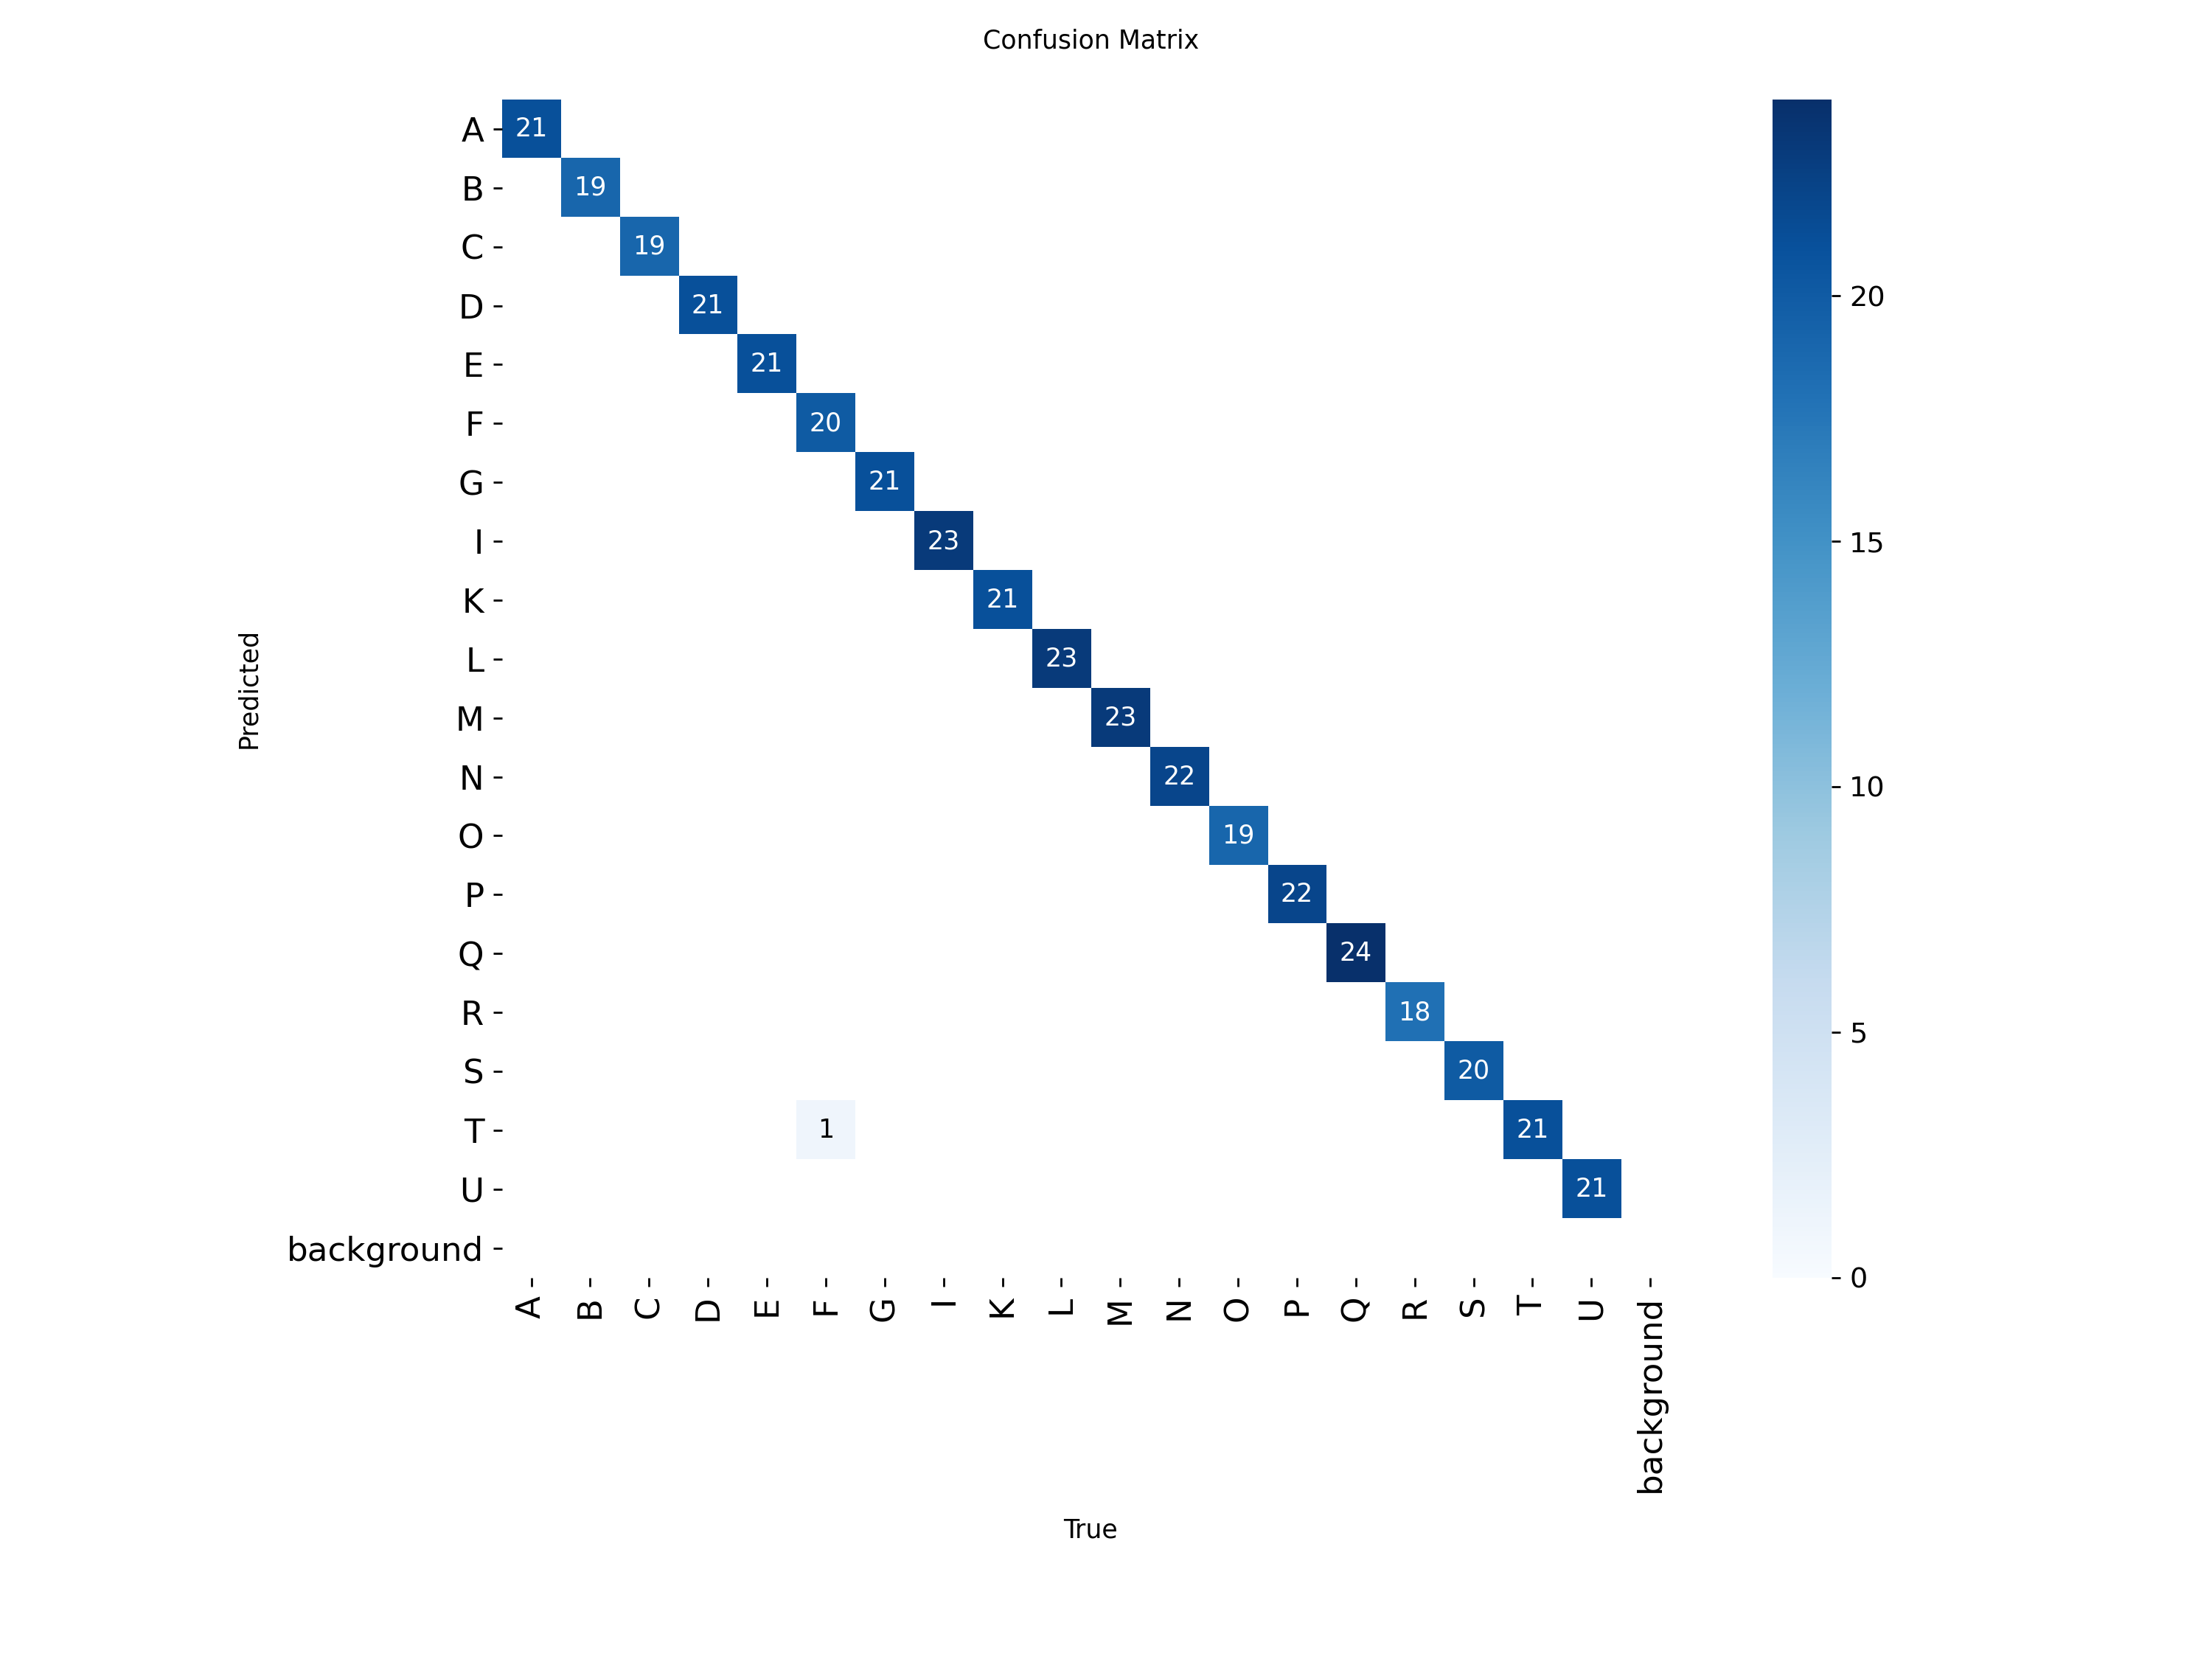

In [11]:
Image(filename=f'runs/detect/train2/confusion_matrix.png', width=600)

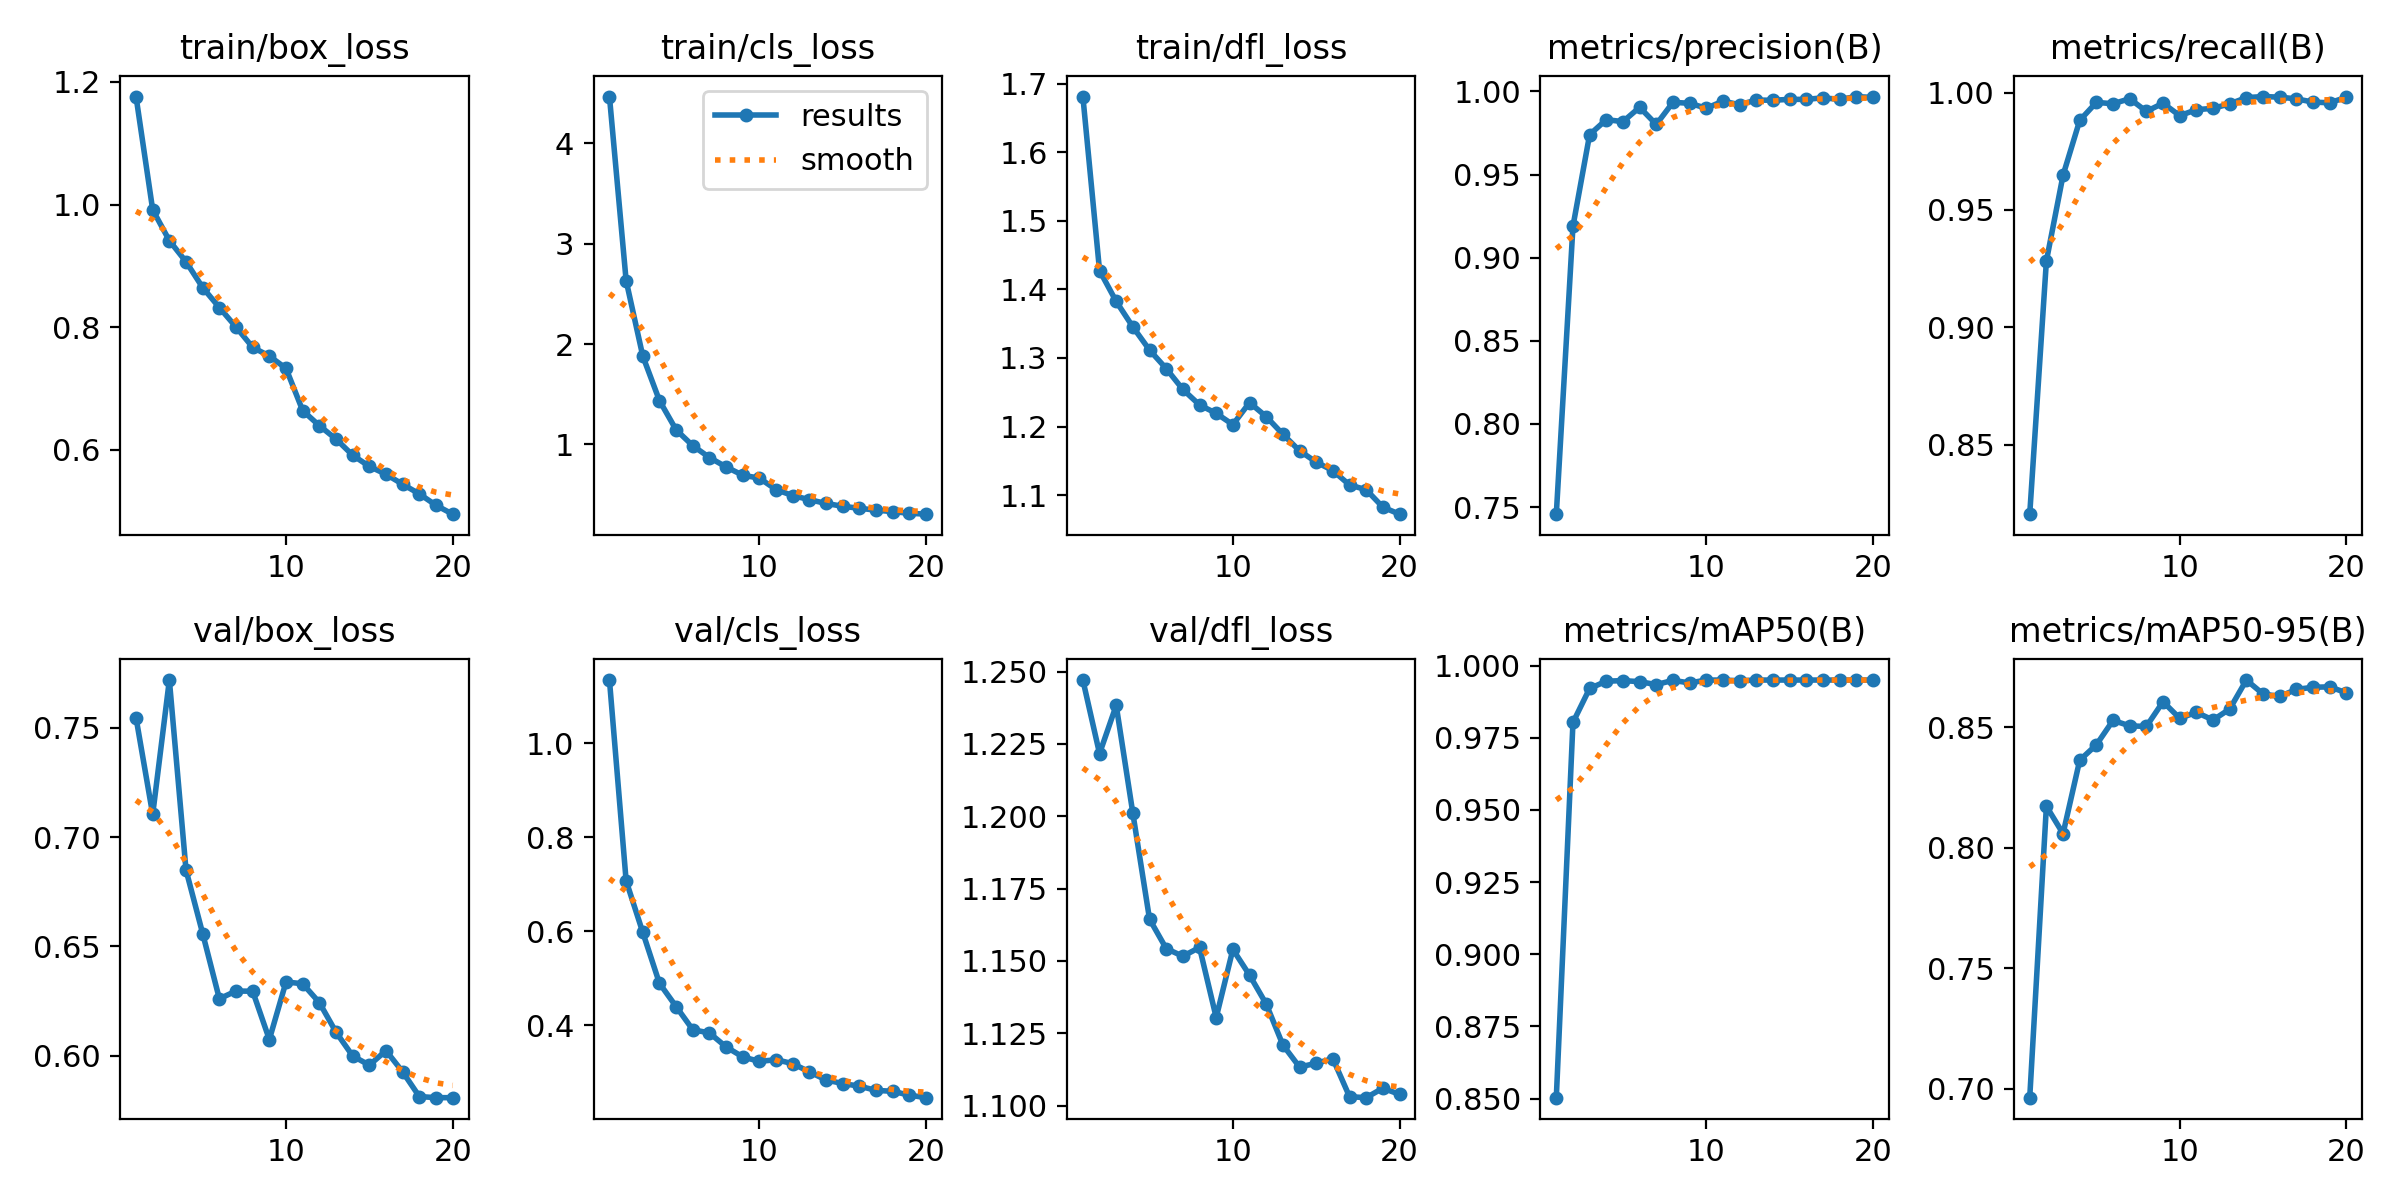

In [12]:
Image(filename=f'runs/detect/train2/results.png', width=600)

In [ ]:
model  = YOLO("best.pt")
model.predict(source="LSE_ADRIAN_SIGNS_BACKGROUND.mp4", save=True, conf=0.25) #guarda en runs/detect/predictNprediccion


WARNING 
inference results will accumulate in RAM unless `stream=True` is passed, causing potential out-of-memory
errors for large sources or long-running streams and videos. See https://docs.ultralytics.com/modes/predict/ for help.

Example:
    results = model(source=..., stream=True)  # generator of Results objects
    for r in results:
        boxes = r.boxes  # Boxes object for bbox outputs
        masks = r.masks  # Masks object for segment masks outputs
        probs = r.probs  # Class probabilities for classification outputs

video 1/1 (frame 1/610) f:\Documentos\Master\TFM\Recursos\LSE_ADRIAN_SIGNS_BACKGROUND.mp4: 640x1088 (no detections), 82.5ms
video 1/1 (frame 2/610) f:\Documentos\Master\TFM\Recursos\LSE_ADRIAN_SIGNS_BACKGROUND.mp4: 640x1088 1 F, 71.1ms
video 1/1 (frame 3/610) f:\Documentos\Master\TFM\Recursos\LSE_ADRIAN_SIGNS_BACKGROUND.mp4: 640x1088 (no detections), 66.1ms
video 1/1 (frame 4/610) f:\Documentos\Master\TFM\Recursos\LSE_ADRIAN_SIGNS_BACKGROUND.mp4: 640x1088

[ultralytics.engine.results.Results object with attributes:
 
 boxes: ultralytics.engine.results.Boxes object
 keypoints: None
 masks: None
 names: {0: 'A', 1: 'B', 2: 'C', 3: 'D', 4: 'E', 5: 'F', 6: 'G', 7: 'I', 8: 'K', 9: 'L', 10: 'M', 11: 'N', 12: 'O', 13: 'P', 14: 'Q', 15: 'R', 16: 'S', 17: 'T', 18: 'U'}
 obb: None
 orig_img: array([[[194, 197, 202],
         [194, 197, 202],
         [194, 197, 202],
         ...,
         [129, 129, 129],
         [129, 129, 129],
         [129, 129, 129]],
 
        [[194, 197, 202],
         [194, 197, 202],
         [194, 197, 202],
         ...,
         [129, 129, 129],
         [129, 129, 129],
         [129, 129, 129]],
 
        [[192, 195, 200],
         [192, 195, 200],
         [192, 195, 200],
         ...,
         [129, 129, 129],
         [129, 129, 129],
         [129, 129, 129]],
 
        ...,
 
        [[135, 104,  85],
         [135, 104,  85],
         [135, 104,  85],
         ...,
         [150, 135, 117],
         [150, 13

# STREAMING


In [ ]:
model  = YOLO("best.pt") # ultima versión de yolo entrenada

In [3]:
print(cv2.__version__)

4.12.0


In [4]:
camera = cv2.VideoCapture(0)
while True:
    ret, frame = camera.read()
    if not ret:
        break
    results = model(frame, verbose=False)  # seguimiento persistente
    
    annotated_frame = results[0].plot()
    cv2.imshow("Detección YOLO11", annotated_frame)
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
camera.release()
cv2.destroyAllWindows()